<a href="https://www.kaggle.com/code/nityanshukumar/model2-xgboost?scriptVersionId=151455458" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from xgboost import XGBRegressor 
import math

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
# print Dimesnions
print(f"Train Data: Number of Houses are: {train_data.shape[0]} and the number of features for each house are {train_data.shape[1]}")
print(f"Test Data: Number of Houses are: {test_data.shape[0]} and the number of features for each house are {test_data.shape[1]}")

Train Data: Number of Houses are: 1460 and the number of features for each house are 81
Test Data: Number of Houses are: 1459 and the number of features for each house are 80


In [3]:
# We didn't  not drop any feature at this point

# Handling naN values in numeric train (LotFrontage and GarageYrBlt) and test data
train_data = train_data.fillna(value=dict(train_data.select_dtypes(include=['int','float']).mean()))
test_data  = test_data.fillna(value=dict(train_data.select_dtypes(include=['int','float']).mean()))

# Converting naN values in object data to NA as it means amenity doesn't exit but the data does exit
train_data = train_data.fillna(value='NA')
test_data = test_data.fillna(value='NA')

In [4]:
# Ordinal Data to Numeric data for Regression 
Replacement_nums = {"LandSlope": {"Gtl": 1,"Mod": 2,"Sev": 3},                                             
                    "ExterQual": {'Po':0, 'Fa': 1, 'TA':2, 'Gd':3,  'Ex': 4},
                    "ExterCond": {'Po':0, 'Fa': 1, 'TA':2, 'Gd':3,  'Ex': 4},
                    "BsmtQual":{'NA':0 , 'Po':1, 'Fa':2, 'TA':3, 'Gd':4,  'Ex': 5},
                    "BsmtCond": {'NA':0 , 'Po':1, 'Fa':2, 'TA':3,'Gd':4, 'Ex': 5},
                    "BsmtExposure": {'NA':0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4},
                    "BsmtFinType1": {'NA':0,'Unf':1,'LwQ':2, 'Rec':3,'BLQ':4,'ALQ':5, 'GLQ':6},
                    "BsmtFinType2": {'NA':0,'Unf':1,'LwQ':2, 'Rec':3,'BLQ':4,'ALQ':5, 'GLQ':6},
                    "HeatingQC": {'Po':0,'Fa':1,'TA':2,'Gd':2,'Ex':3},
                    "CentralAir": {'N':0,'Y':1},
                    "KitchenQual": {'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5},
                    "FireplaceQu": {'NA':0 , 'Po':1, 'Fa':2, 'TA':3,'Gd':4, 'Ex': 5},
                    "GarageFinish": {'NA':0 , 'Unf':1, 'RFn':2, 'Fin':3},
                    "GarageQual": {'NA':0 , 'Po':1, 'Fa':2, 'TA':3,'Gd':4, 'Ex': 5},
                    "GarageCond":{'NA':0 , 'Po':1, 'Fa':2, 'TA':3,'Gd':4, 'Ex': 5},
                    "PavedDrive": {'N':0, 'P':1,'Y':2},
                    "PoolQC": {'NA':0 , 'Fa':1, 'TA':2,'Gd':3, 'Ex': 4}
                                                   }
train_data = train_data.replace(Replacement_nums)
test_data = test_data.replace(Replacement_nums)

In [5]:
# # Selecting the columns based on Pearsson Correlation cutoff
# Corr_Train_M = train_data.select_dtypes(include=['int64','float']).corr()["SalePrice"].round(decimals=2)

# for index,name in enumerate(Corr_Train_M):
#     if abs(Corr_Train_M[index]) < 0.1:
#         print(f"Correlation less than 0.1 for {Corr_Train_M.index[index]} : {Corr_Train_M[index]}")
#         for item in list(train_data.columns):
#             if Corr_Train_M.index[index] == item:
#                 print(f"Item Delted: {item}")
#                 del train_data[Corr_Train_M.index[index]]
#                 del test_data[Corr_Train_M.index[index]]

In [6]:
# Categorical Data: One-hot Encoding list
Categorical_list1 = list(train_data.select_dtypes(include=['object']).columns)
train_data = pd.get_dummies(train_data,prefix=Categorical_list1,columns=Categorical_list1,dtype=int)
Categorical_list2 = list(test_data.select_dtypes(include=['object']).columns)
test_data = pd.get_dummies(test_data,prefix=Categorical_list2,columns=Categorical_list2,dtype=int)

In [7]:
train_X = train_data.loc[:,(train_data.columns != 'SalePrice') & (train_data.columns != 'Id')]
train_Y = train_data['SalePrice']
test_X = test_data.loc[:,test_data.columns != 'Id']

In [8]:
# Inserting the features in test data which are not present in test data
In_Train_Not_Test = []
for i in train_X.columns:
    if i not in test_X.columns:
        test_X.insert(test_X.shape[1],i,0)
        In_Train_Not_Test.append(i)

In_Test_Not_Train = []     
for i in test_X.columns:
    if i not in train_X.columns:
        In_Test_Not_Train.append(i)

# Dropping the features in test data which are not present in train data
test_X = test_X.drop(columns=In_Test_Not_Train)
# Making the column order same in feature vectors
test_X = test_X[train_X.columns]

In [9]:
print(f"Shape of train_X: {train_X.shape} and test_X: {test_X.shape}")

Shape of train_X: (1460, 239) and test_X: (1459, 239)


In [10]:
# Splitting trainning data for cross validation (model selection)
train_X, CV_X, train_Y, CV_Y = train_test_split(train_X,train_Y,test_size=0.20,random_state=1)

# #To train model on complete data
# CV_X = train_X
# CV_Y = train_Y

In [11]:
# Pruning Required
# mean_squared_error and mean_squared_log_error
xgb_model = XGBRegressor(n_estimators=500,max_depth=2,learning_rate=0.1,eval_metric=mean_squared_log_error,reg_lambda=10,verbosity=1,random_state = 10,early_stopping_rounds=10)
xgb_model.fit(train_X,train_Y,eval_set=[(CV_X,CV_Y)])

[0]	validation_0-rmse:80028.41130	validation_0-mean_squared_log_error:0.16889
[1]	validation_0-rmse:76081.55675	validation_0-mean_squared_log_error:0.15307
[2]	validation_0-rmse:72351.06849	validation_0-mean_squared_log_error:0.13842
[3]	validation_0-rmse:69041.11534	validation_0-mean_squared_log_error:0.12606
[4]	validation_0-rmse:66184.48777	validation_0-mean_squared_log_error:0.11656
[5]	validation_0-rmse:63531.77947	validation_0-mean_squared_log_error:0.10712
[6]	validation_0-rmse:61265.28611	validation_0-mean_squared_log_error:0.10012
[7]	validation_0-rmse:59120.18417	validation_0-mean_squared_log_error:0.09319
[8]	validation_0-rmse:56853.49243	validation_0-mean_squared_log_error:0.08635
[9]	validation_0-rmse:54913.96641	validation_0-mean_squared_log_error:0.08021
[10]	validation_0-rmse:53289.51165	validation_0-mean_squared_log_error:0.07533
[11]	validation_0-rmse:51789.45889	validation_0-mean_squared_log_error:0.07111
[12]	validation_0-rmse:50425.48569	validation_0-mean_squared_l

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False,
             eval_metric=<function mean_squared_log_error at 0x7ab3cd829ab0>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=10, ...)

In [12]:
yhat_train_XGB = xgb_model.predict(train_X)
yhat_CV_XGB = xgb_model.predict(CV_X)
RMSE_log2_train = math.sqrt(((np.log2(train_Y) - np.log2(yhat_train_XGB))**2).sum()/len(train_Y))
print(f"The RMSE of log2 of values on training data is: {RMSE_log2_train}")
RMSE_log2_CV = math.sqrt(((np.log2(CV_Y) - np.log2(yhat_CV_XGB))**2).sum()/len(CV_Y))
print(f"The RMSE of log2 of values on CV data is: {RMSE_log2_CV}")

The RMSE of log2 of values on training data is: 0.14147923275244617
The RMSE of log2 of values on CV data is: 0.18855058753567344


R2 value on train data: 0.9494988586044831
R2 value on CV data: 0.8943167502955992


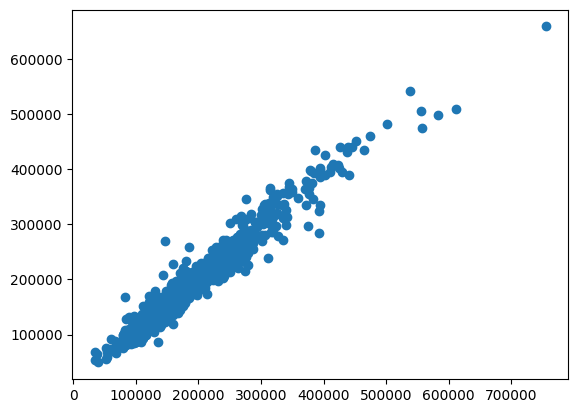

In [13]:
print(f"R2 value on train data: {r2_score(train_Y,yhat_train_XGB)}")
print(f"R2 value on CV data: {r2_score(CV_Y,yhat_CV_XGB)}")
plt.scatter(train_Y,yhat_train_XGB)
plt.show()